# Проектная работа "Стартап по продаже продуктов питания"

## Введение

### Описание проекта

Для стартап по продаже продуктов питания необходимо понять поведение пользователей в мобильном приложении. Дополнительно этого надо разрешить спор между дизайнерами и менеджерами: изменения шрифта во все приложении оттолкнет пользователей или нет.

### Цель проекта

- Проанализировать поведение покупателей.
- Узнать, какие пользователи доходят до покупки.
- Выяснить, какой шрифт лучше

### Ход решения

1. Загрузить файлы с данными и изучить их.
2. Подготовить данные к анализу.
3. Изучить и проверить данные.
4. Изучить воронку событий.
5. Изучить результаты эксперимента.
6. Выводы.

### Описание данных

Структура /datasets/logs_exp.csv:  

•	EventName — название события;  
•	DeviceIDHash — уникальный идентификатор пользователя;  
•	EventTimestamp — время события;  
•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Изучение общей информации и подготовка данных

### Обзор данных

Добавим библиотеки, которые будем использовать при работе в проекте.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except FileNotFoundError:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    print('Проверьте путь к файлу')

In [3]:
data.info()
print()
print('Количество дубликатов:', data.duplicated().sum())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество дубликатов: 413


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Из полученной выше информации можно сделать вывод, что пропусков в данных нет, количество дубликатов составляет 413. Их мы удалим в следующем шаге. Также мы проверили столбец 'EventName' на неявные дубликаты, они отсутствуют. Начнем следующий раздел с поправки названия столбцов, чтобы не были сплошные слова без пробелов.

### Предобработка данных

In [5]:
data.drop_duplicates(inplace=True)
data.columns = ['event_name','device_id_hash','event_timestamp','exp_id']
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [6]:
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = data['event_datetime'].dt.floor('1D')
data

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Как и планировалось, мы удалили дубликаты, исправил названия столбцов, а также создали два столбца: event_datetime (с датой и временем) и event_date (с датой). Данные обработаны, можем переходить к их изучению.

## Изучение и проверка данных

In [7]:
print('Количество событий:', len(data['event_name'].unique()))
print('Количество пользователей:', len(data['device_id_hash'].unique()))

events_per_users = data.groupby('device_id_hash', as_index=False).agg({'event_name':'count'})
print('Среднее количество событий на пользователя:',
     events_per_users['event_name']
     .mean().round(2))

Количество событий: 5
Количество пользователей: 7551
Среднее количество событий на пользователя: 32.28


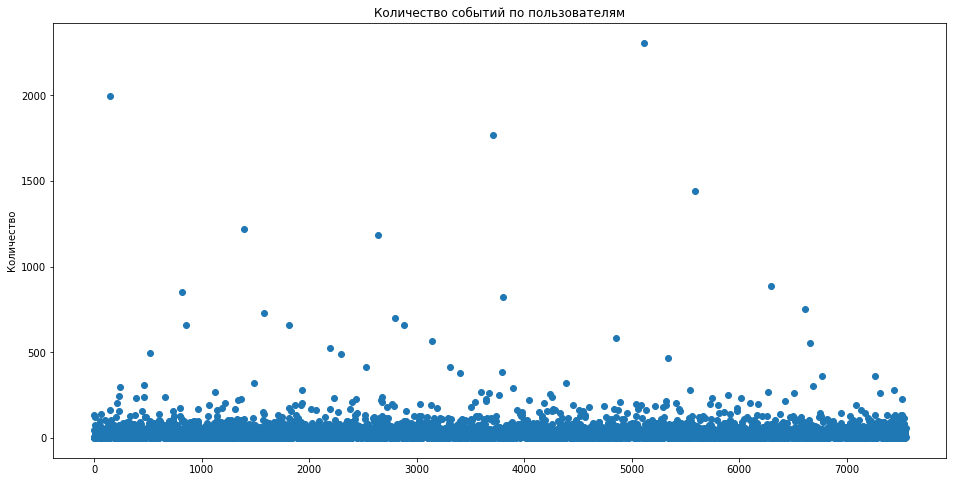

In [8]:
x_value = pd.Series(range(0,len(events_per_users['device_id_hash'])))
plt.figure(figsize=(16,8))
plt.scatter(x_value,events_per_users['event_name'])
plt.title('Количество событий по пользователям')
plt.ylabel('Количество');

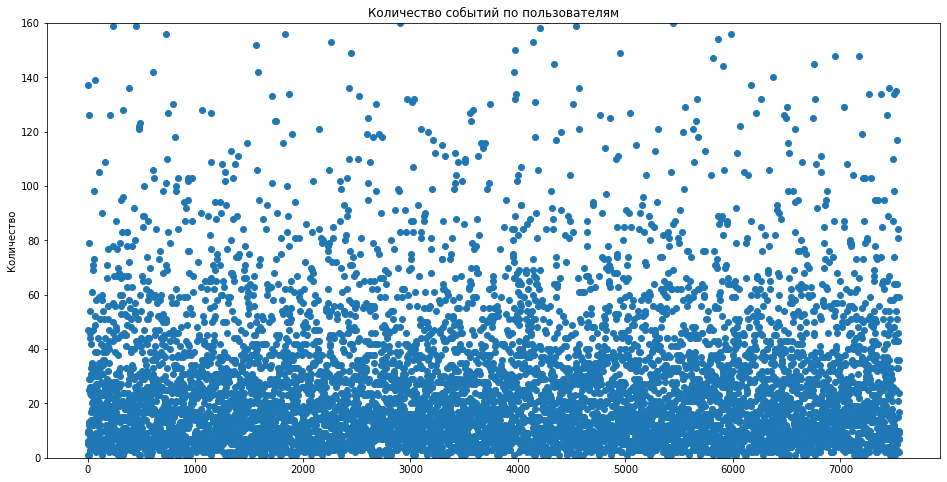

In [9]:
plt.figure(figsize=(16,8))
plt.ylim([0,160])
plt.scatter(x_value,events_per_users['event_name'])
plt.title('Количество событий по пользователям')
plt.ylabel('Количество');

На первом графике видны явные аномалии: количество событий достигает 1000, 1500 и даже больше 2000. Ограничив ось У, количество точек увеличивается приближаясь к 0. Вполне вероятно, что рассчитанное среднее количество событий равное 32.33 является правдой.

In [10]:
pctl_events = np.percentile(events_per_users['event_name'], [90, 95, 99])
pctl_events

array([ 64. ,  89. , 200.5])

Лишь у 5% пользователей количество событий достигает 90.

In [11]:
print('Начало периода:', data['event_date'].min().strftime('%Y-%b-%d'))
print('Конец периода:', data['event_date'].max().strftime('%Y-%b-%d'))

Начало периода: 2019-Jul-25
Конец периода: 2019-Aug-07


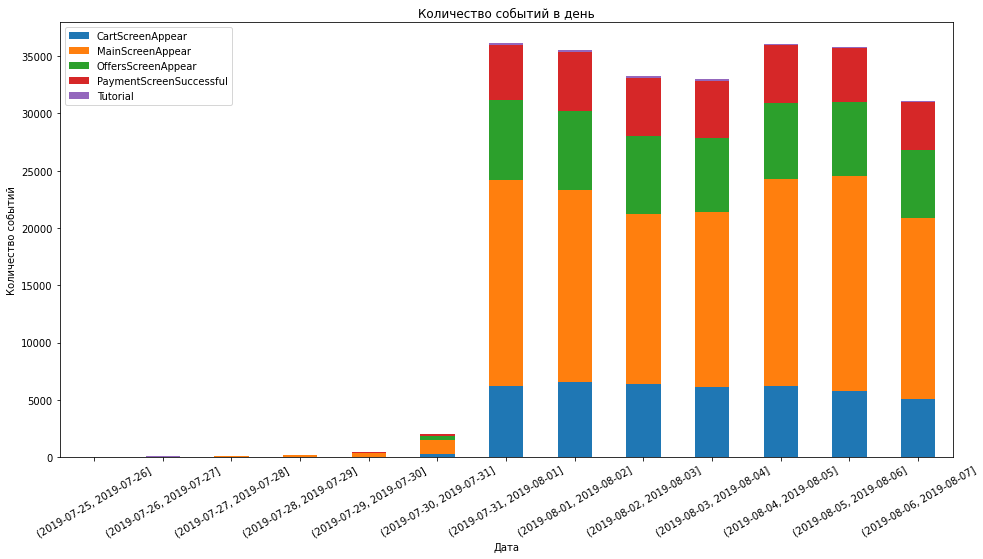

In [12]:
df_plot = pd.crosstab(
    pd.cut(
        x=data['event_date'],
        bins=data['event_date'].unique(),
    ),
    data['event_name']
)



df_plot.plot.bar(stacked=True, figsize=(16,8))

plt.title('Количество событий в день')
plt.legend()
plt.xlabel('Дата')
plt.xticks(rotation=30)

plt.ylabel('Количество событий')

plt.show();

Две важные особенности, которые мы можем подчерпнуть из данного графика:

1. Достаточное количество данных есть, начиная с 31.07.2019.
2. Наибольшее количество раз встречается событие "MainScreenAppear", оно занимает оранжевую часть графика.

In [13]:
df = data.query('event_date > "2019-07-31"')
print('Доля потерянных событий: {}'.format(1-len(df['event_name'])/len(data['event_name'])))
print('Доля потерянных пользователей: {}'.format(1-len(df['device_id_hash'].unique())/len(data['device_id_hash'].unique())))
df

Доля потерянных событий: 0.01159560630741896
Доля потерянных пользователей: 0.0022513574361011646


,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [14]:
#Переименуем группы, для функции далее
def change_group_name(group):
    if group == 246:
        return 'A1'
    elif group == 247:
        return 'A2'
    elif group == 248:
        return 'B'
    
df['exp_id'] = df['exp_id'].apply(change_group_name)
df.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_15828\1417676849.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exp_id'] = df['exp_id'].apply(change_group_name)


,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2828,Tutorial,3737462046622621720,1564618048,A1,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,A1,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,A1,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,A1,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,A2,2019-08-01 00:08:59,2019-08-01


In [15]:
exp_count = df.groupby('exp_id').agg({'device_id_hash':'nunique'}).reset_index()
exp_count['diff'] = ((exp_count['device_id_hash']/exp_count.loc[0,'device_id_hash']-1)*100).round(2)
exp_count

,exp_id,device_id_hash,diff
0,A1,2484,0.00
1,A2,2513,1.17
2,B,2537,2.13


Группы разбиты практически в равном соотношении, разница не превышает 2.5%.

## Воронка событий

In [16]:
df_event = (
    df.groupby('event_name')
    .agg({'event_date':'count','device_id_hash':'nunique'})
    .sort_values(by='event_date', ascending=False)
    .reset_index()
)
df_event.columns = ['event_name','total', 'users']
df_event

,event_name,total,users
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


Наиболее частое событие - открытие главного экрана, очевидно, что данный пункт нельзя пропустить, чтобы приобрести товар. Следующем по количеству идет OffersScreenAppear, около 4,5 тыс переходов. Затем идут шаги: CartScreenAppear и PaymentScreenSuccessfulю. Наименьшее количество переходов в раздел Tutorial, скорее всего переход в данный раздел необязательный для покупки товаров.

In [17]:
df_event = df_event[:4]
df_event

,event_name,total,users
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539


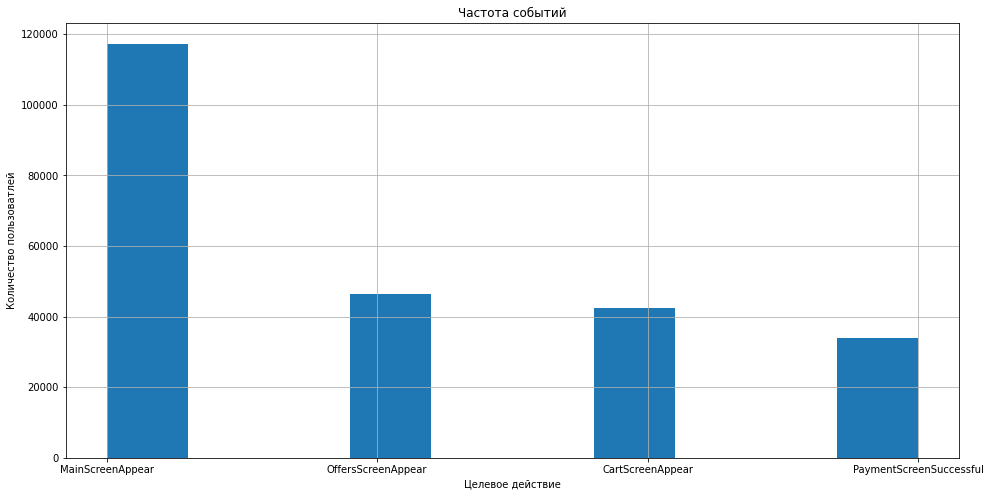

In [18]:
plt.figure(figsize=(16,8))
df.loc[df['event_name'] != 'Tutorial']['event_name'].hist()
plt.title('Частота событий')
plt.ylabel('Количество пользоватлей')
plt.xlabel('Целевое действие')
plt.show()

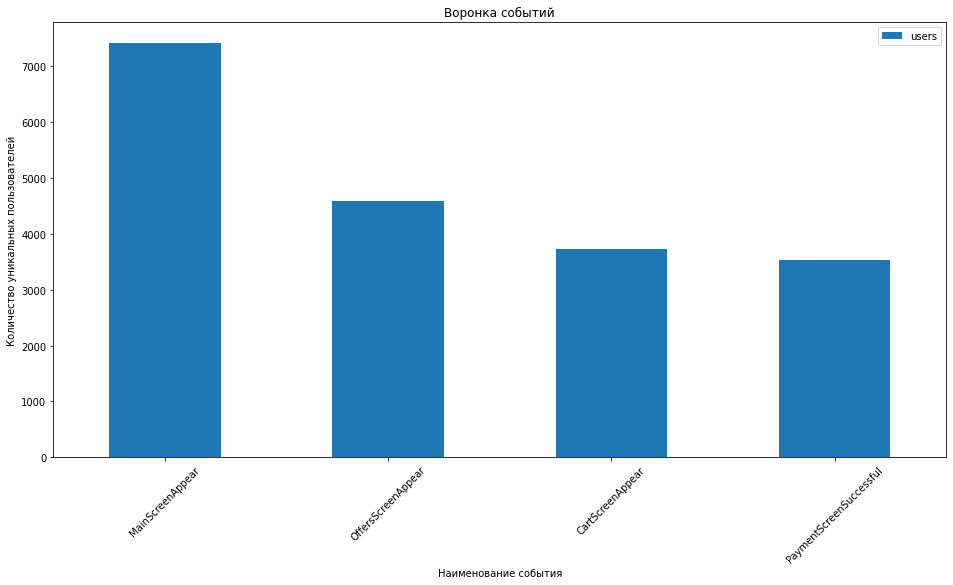

In [19]:
df_event.plot(x='event_name', y='users',kind='bar', figsize=(16,8))

plt.title('Воронка событий')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Наименование события')
plt.xticks(rotation=45)
plt.show()

Наиболее частое событие - открытие главного экрана, очевидно, что данный пункт нельзя пропустить, чтобы приобрести товар. Следующем по количеству идет OffersScreenAppear, около 4,5 тыс переходов. Затем идут шаги: CartScreenAppear и PaymentScreenSuccessful.

In [20]:
df_event['ratio'] = (df_event['users'] / len(df['device_id_hash'].unique())*100).round(2)
df_event['ratio_step'] = (df_event['users']/df_event['users'].shift()*100).round(2)
df_event.loc[0,'ratio_step'] = df_event.loc[0,'ratio']
df_event

C:\Users\User\AppData\Local\Temp\ipykernel_15828\986058958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['ratio'] = (df_event['users'] / len(df['device_id_hash'].unique())*100).round(2)
C:\Users\User\AppData\Local\Temp\ipykernel_15828\986058958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['ratio_step'] = (df_event['users']/df_event['users'].shift()*100).round(2)
C:\Users\User\anaconda3\envs\da_practicum_env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning

,event_name,total,users,ratio,ratio_step
0,MainScreenAppear,117328,7419,98.47,98.47
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


Всего 5 событий. События со следующими индексами последовательны: 
1. MainScreenAppear  
2. OffersScreenAppear
3. CartScreenAppear  
4. PaymentScreenSuccessful  


In [21]:
df_event = df_event[:4]
df_event

,event_name,total,users,ratio,ratio_step
0,MainScreenAppear,117328,7419,98.47,98.47
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


Больше всего пользователей теряем на шаге "добавление товара в корзину", так как у него наименьший процент перехода = 60.64%. До оплаты доходит чуть меньше половины пользователей: 46.38%. По моему мнению, данный процент конвертации пользователей в покупателей очень неплох.

## Эксперимент

In [22]:
#Количество пльзователей в каждой группе
new_row = {'exp_id': 'A1+A2', 'device_id_hash': (exp_count.loc[0,'device_id_hash'] + exp_count.loc[1,'device_id_hash'])}
exp_count = exp_count.append(new_row, ignore_index=True)
exp_count = exp_count[['exp_id','device_id_hash']]
exp_count

,exp_id,device_id_hash
0,A1,2484
1,A2,2513
2,B,2537
3,A1+A2,4997


In [23]:
group_A1 = df[df['exp_id']=='A1']
group_A2 = df[df['exp_id']=='A2']
group_B = df[df['exp_id']=='B']

doplicate_user_A1_A2 = group_A1.query('device_id_hash in @group_A2')['device_id_hash']
doplicate_user_A1_B= group_B.query('device_id_hash in @group_A1')['device_id_hash']
doplicate_user_A2_B = group_B.query('device_id_hash in @group_A2')['device_id_hash']
print(len(doplicate_user_A1_A2))
print(len(doplicate_user_A1_B))
print(len(doplicate_user_A2_B))

0
0
0


Пользователей, попавших в несколько групп экспериментов, нет.

In [24]:
group_test = (
    df.pivot_table(
        index = 'event_name',
        columns = 'exp_id',
        values = 'device_id_hash',
        aggfunc = 'nunique'
    )
    .sort_values(by='A1', ascending=False)
    .reset_index()
)
#добавим столбец для скомбинированных данных
group_test['A1+A2'] = group_test['A1'] + group_test['A2']
group_test

exp_id,event_name,A1,A2,B,A1+A2
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


In [25]:
for group in exp_count['exp_id']:
    group_test[group+'_share'] = (
        group_test[group] / exp_count[exp_count['exp_id']==group]['device_id_hash'].values[0]*100).round(1)
    
group_test

exp_id,event_name,A1,A2,B,A1+A2,A1_share,A2_share,B_share,A1+A2_share
0,MainScreenAppear,2450,2476,2493,4926,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.3,46.1,46.6,47.2
4,Tutorial,278,283,279,561,11.2,11.3,11.0,11.2


Гипотезы:\
Н0: между долями в событиях в группах нет разницы\
Н1: между долями в событиях в группах есть разница

In [26]:
alpha = 0.05
nobs = [exp_count.device_id_hash[0], exp_count.device_id_hash[1]]

In [27]:
def group_comparison(group_share_1, group_share_2):
    
    print(f'в группах {group_share_1} и {group_share_2}:')
    print()
    for event in range(len(group_test)):
        count = [group_test[group_share_1][event], group_test[group_share_2][event]]
        stat, pval = proportions_ztest(count, nobs)
        print(f'- для события {group_test["event_name"][event]} p-value равно {pval} =>')
        if pval < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
        print()

In [28]:
group_comparison('A1', 'A2')

в группах A1 и A2:

- для события MainScreenAppear p-value равно 0.7570597232046099 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.2480954578522181 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.22883372237997213 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.11456679313141847 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.9376996189257114 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [29]:
#Проверка кода старым методом
alpha = 0.05
total_a1 = len(df[df['exp_id'] == 'A1']['device_id_hash'].unique())
total_a2 = len(df[df['exp_id'] == 'A2']['device_id_hash'].unique())
for value in range(len(group_test.event_name.tolist())):
    count = [group_test['A1'][value], group_test['A2'][value]]
    nobs = [total_a1, total_a2]
    stat, pval = proportions_ztest(count, nobs)
    print()
    print('P-value on step ', group_test.event_name.tolist()[value], ':')
    print(pval)
    if pval < alpha:
        print('Отвергаем нулевую гипотезу, между долями есть разница.')
    else:
        print('Не отвергаем нулевую гипотезу, между долями нет разницы.')


P-value on step  MainScreenAppear :
0.7570597232046099
Не отвергаем нулевую гипотезу, между долями нет разницы.

P-value on step  OffersScreenAppear :
0.2480954578522181
Не отвергаем нулевую гипотезу, между долями нет разницы.

P-value on step  CartScreenAppear :
0.22883372237997213
Не отвергаем нулевую гипотезу, между долями нет разницы.

P-value on step  PaymentScreenSuccessful :
0.11456679313141847
Не отвергаем нулевую гипотезу, между долями нет разницы.

P-value on step  Tutorial :
0.9376996189257114
Не отвергаем нулевую гипотезу, между долями нет разницы.


Итог: две контрольные группы разбиты правильно, так как ни для одного события мы не смогли отвергнуть гипотезу об отсутствии разницы.

In [30]:
nobs = [exp_count.device_id_hash[0], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A1', 'B')

в группах A1 и B:

- для события MainScreenAppear p-value равно 0.2949721933554553 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.20836205402738917 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.07842923237520125 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.21225532756977972 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.8264294010087645 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [31]:
nobs = [exp_count.device_id_hash[1], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A2', 'B')

в группах A2 и B:

- для события MainScreenAppear p-value равно 0.45870536166215137 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.919781783059226 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.5786197879539782 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.7373415053803964 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.7653239224745011 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Значение P-value не пересекает стаистическую знаичомость ни для одной из контрольных групп в сравнении с экспериментальной группой. 

In [32]:
#Определим статистическую значимость для групп B и скомбинированных контрольных групп
nobs = [exp_count.device_id_hash[3], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A1+A2', 'B')

в группах A1+A2 и B:

- для события MainScreenAppear p-value равно 0.29424526837179577 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.43425549655188245 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.18175875284404386 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.6004294282308703 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.764862472531507 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравнив скомбинированную группу из контрольных групп с экспериментальной, мы снова получаем, что нулевую гипотезу отвергать нельзя.

Однако, при проверке гипотез, мы использовали стат. значимость = 0.05.
Но мы не учли, что у нас 5 событий и 4 группы, то есть 20 гипотез.

In [33]:
#Критический уровень статистической значимости с поправкой Шидака
alpha = 1 - (1 - 0.05)**(1/20) 

In [34]:
#Проверим правильную разбивку на группы для контрольных групп:
nobs = [exp_count.device_id_hash[0], exp_count.device_id_hash[1]]
group_comparison('A1', 'A2')

в группах A1 и A2:

- для события MainScreenAppear p-value равно 0.7570597232046099 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.2480954578522181 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.22883372237997213 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.11456679313141847 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.9376996189257114 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Группы разбиты корректно, так как нам не удалось отвергнуть нулевую гипотезу.

In [35]:
nobs = [exp_count.device_id_hash[0], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A1', 'B')

в группах A1 и B:

- для события MainScreenAppear p-value равно 0.2949721933554553 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.20836205402738917 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.07842923237520125 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.21225532756977972 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.8264294010087645 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [36]:
nobs = [exp_count.device_id_hash[1], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A2', 'B')

в группах A2 и B:

- для события MainScreenAppear p-value равно 0.45870536166215137 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.919781783059226 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.5786197879539782 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.7373415053803964 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.7653239224745011 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [37]:
nobs = [exp_count.device_id_hash[3], exp_count.device_id_hash[2]] # число польз-лей в гр. А_1 и В

group_comparison('A1+A2', 'B')

в группах A1+A2 и B:

- для события MainScreenAppear p-value равно 0.29424526837179577 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события OffersScreenAppear p-value равно 0.43425549655188245 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события CartScreenAppear p-value равно 0.18175875284404386 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события PaymentScreenSuccessful p-value равно 0.6004294282308703 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

- для события Tutorial p-value равно 0.764862472531507 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Несмотря на исправленное значение статистической значимости, результаты экспериментов не изменились. Контрольные группы не имеют достаточной разницы с экспериментальной. 

В конечном счете, мы проверили 20 гипотез по каждому событию для разных комбинаций групп. Изменения статистической значимости, не повлияли на результаты, но лучше использовать уровень статистической значимости с поправкой Шидака. Так мы уменьшаем вероятность ошибки первого рода (ложнопозитивный результат).

## Вывод

В данном проекте мы изучали поведение пользователей в приложении по покупки продуктов:\
1 этап: обзор и подготовка данных;\
2 этап: изучение и проверка данных;\
3 этап: формироание воронки событий;\
4 этап: эксперимент.

На 1 этапе мы столкнулись с нечитабильным названиями столбцов, дубликатами и датами, записанными одним числом. На это шаге мы обработали данные для дальнейшей работы.

На 2 этапе было выявлено, что каждый из 7551 пользователей с разной частотой открывает главный экран или переходит на страницу оплаты. Всего таких событий 5: наиболее частое - открытие главного экрана, наименее частое - страница с инструкцией. Среднее значение находится около 32, но есть пользователи, у которых количество событий достигает 1500. Наиболее полная картина по переходу пользователей с одного шага на другой видна с 31.07.2019, при анализе мы использовали события произошедшие после этой даты. В конце данного этапа мы проверили соотношение пользователей в группах, разница составляла до 2,5%.

3 этап - этап определение последовательностей действий пользователей или, другими словами, воронки событий. Сгруппировав данные по событиям и построив график, мы сделали предположение, что последовательность действий следующая:
1. MainScreenAppear  
2. OffersScreenAppear
3. CartScreenAppear  
4. PaymentScreenSuccessful  

Шаг "Tutorial" мы не стали включать, так как нет определенности в том, в каком случае и когда пользователи переходят на эту страницу.
Помимо этого, мы выяснили, что наибольшее потери при переходе с одного шага на другой происходят на этапе перехода с главного экрана на экран корзины. И доля пользователей, открывших сайт и оплативших покупку, составляет 46,38%

На последнем этапе, был проведен A/B-тест. Первоначально мы задали уровень статистической значимости равным 0.05. Проверили отличие между двумя контрольными группами,  а также между каждой из контрольных групп с экспериментальной группой. Разница не была выявлена. Скомбинировав контрольные группы и сравнив их с экспериментальной, мы снова не получили достаточных оснований, чтобы отвергнуть гипотезу об их равенстве. Но для снижения вероятности ошибки первого рода, мы рассчитали уровень статистической значимости с поправкой Шидака. Изменений в результатх не было выявлено, но стало намного спокойнее.

Рекомндации для отдела маркетинга следующие:

1. С переходом к следующему этапу мы теряем пользоватлей и к оплате переходят чуть меньше 50% пользователей. Это не является катастрофическим, но определенно есть куда расти.
2. Изменение шрифта никак не изменило поведение пользователей. Соответственно опасения, что из-за изменения шрифта пользователи менше будут конвертироваться в покупателей не обоснована, шрифт можно менять. Но с другой стороны изменения шрифта никак не увеличило корзину покупателей, поэтому явных причин для изменения шрифта не определены.
3. Сравнение с комбинированной группой дало повод отвергнуть нулевую гипотезу об отсутствии различий с экспериментальной группой. Но из-за неравномерного разделения между группами полагаться на полученные данные не стоит. 